**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip install nltk
!pip install wordcloud
!pip install tensorflow

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import nltk, re, collections, pickle, os # nltk - Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings(action = "ignore")
warnings.simplefilter(action = 'ignore', category = Warning)
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

# %matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')
seed = 42


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
#pd.set_option("precision", 3)
#pd.options.display.float_format = '{:.3f}'.format

**Reading the Dataset**

In [6]:
df_spam = pd.read_csv('/content/spam.csv', encoding = 'latin-1')

In [7]:
df_spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [8]:
# Dropping the redundent looking collumns (for this project)
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
df_spam = df_spam.drop(df_spam[to_drop], axis=1)
# Renaming the columns because I feel fancy today
df_spam.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
df_spam.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df_spam.drop_duplicates(inplace = True, ignore_index = True)
print('Number of null values:\n')
df_spam.isnull().sum()

Number of null values:



Target    0
Text      0
dtype: int64

The dataset consists of 5,574 messages in English. The data is designated as being ham or spam. Dataframe has two columns. The first column is "Target" indicating the class of message as ham or spam and the second "Text" column is the string of text.

In [10]:
df_spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5169 non-null   object
 1   Text    5169 non-null   object
dtypes: object(2)
memory usage: 80.9+ KB


                                                          **DATA EXPLORATION**

Text(0, 0.5, 'Number of Data points')

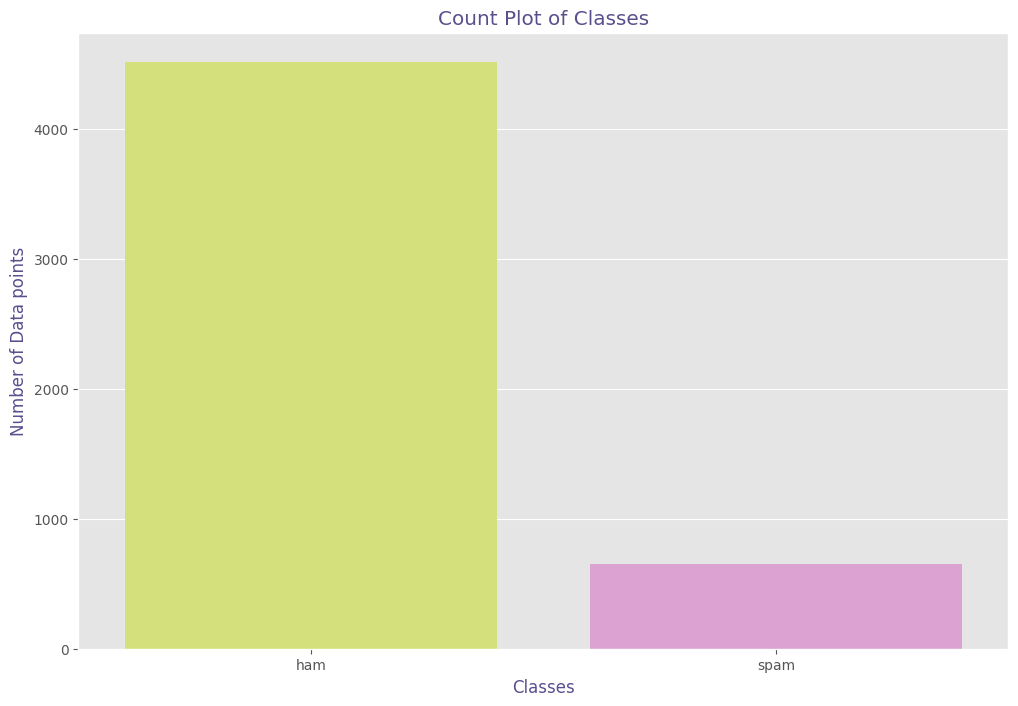

In [11]:
#Palette
cols= ["#E1F16B", "#E598D8"]
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= df_spam["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

The number of ham messages is almost for times bigger than that of spam messages in the data.



**FEATURE ENGINEERING**

For the purpose of data exploration, I am creating new features

No_of_Characters: Number of characters in the text message
No_of_Words: Number of words in the text message
No_of_sentence: Number of sentences in the text message

In [12]:
#Adding a column of numbers of charachters,words and sentences in each msg
df_spam["No_of_Characters"] = df_spam["Text"].apply(len)
df_spam["No_of_Words"]=df_spam.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
df_spam["No_of_sentence"]=df_spam.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

df_spam.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,910.0
No_of_Words,5169.0,18.455794,13.324758,1.0,9.0,15.0,26.0,220.0
No_of_sentence,5169.0,1.965564,1.448541,1.0,1.0,1.0,2.0,38.0


<Figure size 1200x800 with 0 Axes>

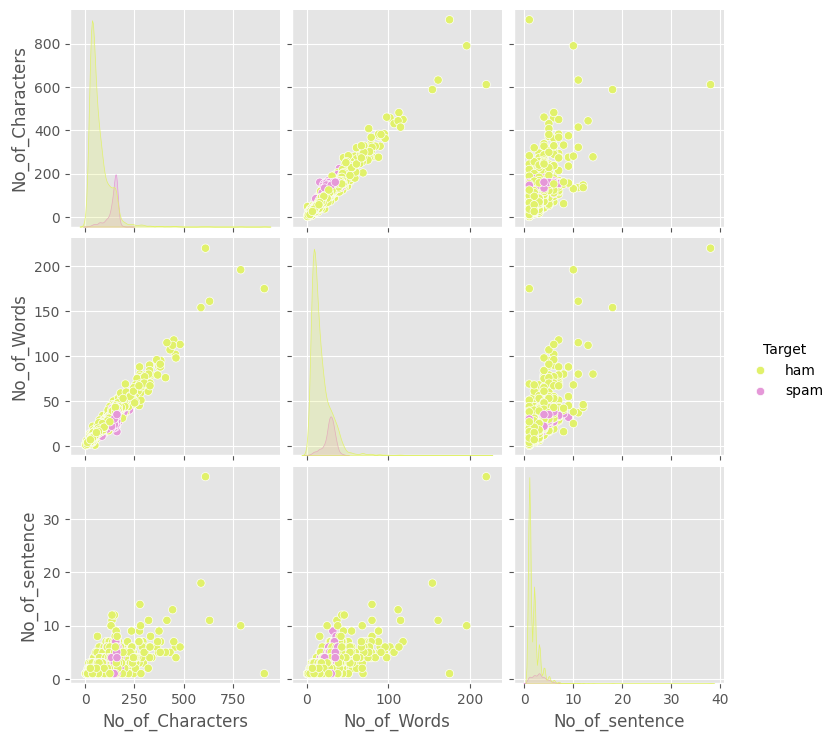

In [13]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df_spam, hue="Target",palette=cols)
plt.show(fg)

Conclusion: From the pair plot, we can see a few outliers all in the class ham. As they essentially indicate the same thing ie the length of SMS.

Next, I shall be dropping the outliers


REMOVING OUTLIERS

In [14]:
#Dropping the outliers.
df_spam = df_spam[(df_spam["No_of_Characters"]<350)]
df_spam.shape

(5149, 5)

<Figure size 1200x800 with 0 Axes>

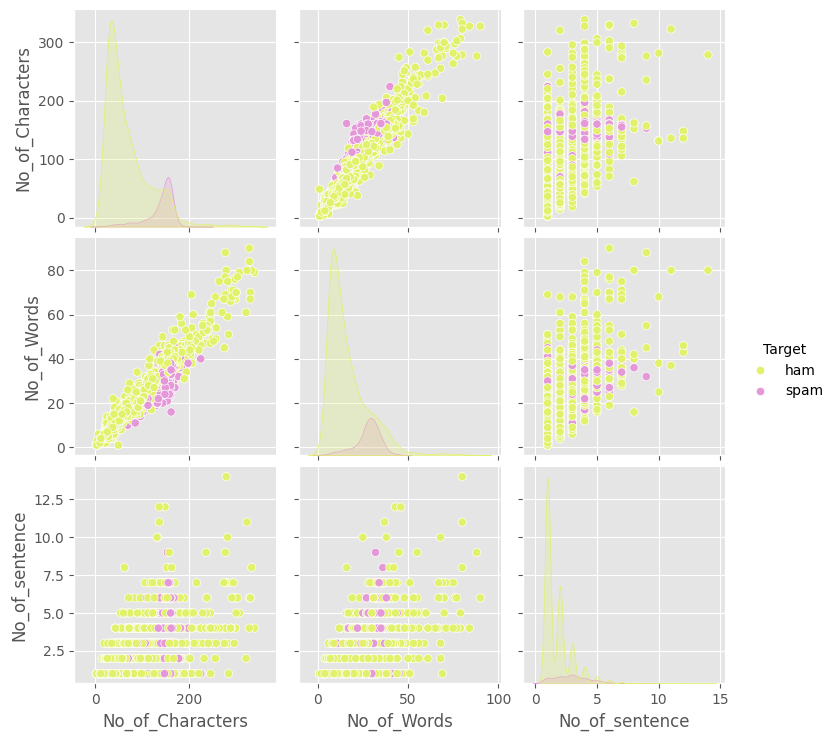

In [15]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df_spam, hue="Target",palette=cols)
plt.show(fg)

                                                              **DATA CLEANING**

The data cleaning process NLP is crucial. The computer doesn’t understand the text. for the computer, it is just a cluster of symbols. To further process the data we need to make the data cleaner.

1.In the first step we extract only the alphabetic characters by this we are removing punctuation and numbers.

2.In the next step, we are converting all the characters into lowercase.
This text will be then used in further procrssing

In [16]:
#Lets have a look at a sample of texts before cleaning
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*df_spam["Text"][:5], sep = "\n")

 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [17]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df_spam["Clean_Text"] = df_spam["Text"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*df_spam["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


Successfully clean text

                                                                 
                                                              ***TOKENIZATION***

Tokenization is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words. I am splitting the Clean_Text into words at this step.

In [18]:
df_spam["Tokenize_Text"]=df_spam.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*df_spam["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


                                                 **REMOVING STOPWORDS**

Stopwords are frequently occurring words(such as few, is, an, etc). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing.

In [19]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df_spam["Nostopword_Text"] = df_spam["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*df_spam["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


                                                                
                                                                 
                                                                  
                                                            **LEMMATIZATION**

Stemming is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

lemmatization also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English.

In [20]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

df_spam["Lemmatized_Text"] = df_spam["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*df_spam["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


                                                         **VECTORIZATION**

TF-IDF in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents) Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.

Steps in the Vectorizing:

Creating a corpus of lemmatized text
Converting the corpus in vector form
Label Encoding the classes in Target


In [21]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in df_spam["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Changing text data in to numbers.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature
X.dtype

dtype('float64')

In [23]:
from sklearn.preprocessing import LabelEncoder
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
df_spam["Target"] = label_encoder.fit_transform(df_spam["Target"])

                                                          **MODEL BUILDING**

Steps involved in the Model Building

1.Setting up features and target as X and y
2.Splitting the testing and training sets
3.Build a pipeline of model for four different classifiers.
    Naïve Bayes
    RandomForestClassifier
    KNeighborsClassifier
    Support Vector Machines
4.Fit all the models on training data
5.Get the cross-validation on the training set for all the models for accuracy

In [24]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = df_spam["Target"]
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model-1 MultinomialNB**

In [29]:
# create and train the Multi Naive Bayes Classifier
clf_MNB = MultinomialNB().fit(X_train, y_train)

In [30]:
print(clf_MNB.predict(X_train))
print(y_train.values)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [31]:
# Evaluating the model on the training data set
from sklearn.metrics import accuracy_score
pred_MNB = clf_MNB.predict(X_train)
print(classification_report(y_train, pred_MNB))
print()
print("Confusion Matrix: \n", confusion_matrix(y_train, pred_MNB))
print("Accuracy: \n", accuracy_score(y_train, pred_MNB))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3580
           1       1.00      0.80      0.89       539

    accuracy                           0.97      4119
   macro avg       0.99      0.90      0.94      4119
weighted avg       0.97      0.97      0.97      4119


Confusion Matrix: 
 [[3580    0]
 [ 108  431]]
Accuracy: 
 0.9737800436999272


**Result :**It looks like the model used is 97.37% accurate. Let’s test the model on the test data set (xtest &  ytest) by printing the predicted value, and the actual value to see if the model can accurately classify the email text.

**Now let’s evaluate the model on the test data set :**

In [32]:
# Evaluating the model on the training data set
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred_test = clf_MNB.predict(X_test)
print(classification_report(y_test, pred_test))
print()
print("Confusion Matrix: \n", confusion_matrix(y_test, pred_test))
print("Accuracy: \n", accuracy_score(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       916
           1       1.00      0.75      0.85       114

    accuracy                           0.97      1030
   macro avg       0.98      0.87      0.92      1030
weighted avg       0.97      0.97      0.97      1030


Confusion Matrix: 
 [[916   0]
 [ 29  85]]
Accuracy: 
 0.9718446601941747


**Model - 2 Random Forest**

In [33]:
# create and train the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier().fit(X_train, y_train)

In [34]:
# Evaluating the model on the training data set

pred_rf = clf_rf.predict(X_train)
print(classification_report(y_train, pred_rf))
print()
print("Confusion Matrix: \n", confusion_matrix(y_train, pred_rf))
print("Accuracy: \n", accuracy_score(y_train, pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3580
           1       1.00      1.00      1.00       539

    accuracy                           1.00      4119
   macro avg       1.00      1.00      1.00      4119
weighted avg       1.00      1.00      1.00      4119


Confusion Matrix: 
 [[3580    0]
 [   0  539]]
Accuracy: 
 1.0


In [35]:
# Evaluating the model on the training data set
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred_test = clf_rf.predict(X_test)
print(classification_report(y_test, pred_test))
print()
print("Confusion Matrix: \n", confusion_matrix(y_test, pred_test))
print("Accuracy: \n", accuracy_score(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       916
           1       1.00      0.82      0.90       114

    accuracy                           0.98      1030
   macro avg       0.99      0.91      0.95      1030
weighted avg       0.98      0.98      0.98      1030


Confusion Matrix: 
 [[916   0]
 [ 20  94]]
Accuracy: 
 0.9805825242718447


Model-3 Support Vector

In [36]:
# create and train the Random Forest Classifier

clf_svc = SVC().fit(X_train, y_train)

In [37]:
# Evaluating the model on the training data set

pred_svc = clf_svc.predict(X_train)
print(classification_report(y_train, pred_svc))
print()
print("Confusion Matrix: \n", confusion_matrix(y_train, pred_svc))
print("Accuracy: \n", accuracy_score(y_train, pred_svc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3580
           1       1.00      0.98      0.99       539

    accuracy                           1.00      4119
   macro avg       1.00      0.99      1.00      4119
weighted avg       1.00      1.00      1.00      4119


Confusion Matrix: 
 [[3580    0]
 [   9  530]]
Accuracy: 
 0.9978150036416606


In [38]:
# Evaluating the model on the training data set

pred_test = clf_svc.predict(X_test)
print(classification_report(y_test, pred_test))
print()
print("Confusion Matrix: \n", confusion_matrix(y_test, pred_test))
print("Accuracy: \n", accuracy_score(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       916
           1       0.98      0.80      0.88       114

    accuracy                           0.98      1030
   macro avg       0.98      0.90      0.93      1030
weighted avg       0.98      0.98      0.97      1030


Confusion Matrix: 
 [[914   2]
 [ 23  91]]
Accuracy: 
 0.9757281553398058


**Conclusion :**

1. **For Multi Naive Bayes Classifier :**

  Training Score : 97.37%

  Testing Score :97.18%

2.  **Random Forest Classifier : **

  Training Score : 100%

  Testing Score: 98.05%

3.  **SVC : **

  Training score:99.78%

  Testing Score:97.57%

All three classifier accurately identified the e-mail messages as spam or not spam with accuracy score more than 95
% on the test data.

